# KNN or Decision Tree or some kind of LP
This notebook is my script to take the feature code data from Navistar and use it to produce a recommendation for decking configuration.  Deck loads can be either ZWing, Combo, or Single.  ZWing loads can contain 3 units and Combo loads can contain 4 units.

There are many features of the units not captured by this data, so they are "paired" manually by supervisors.  The goal of this script is to eliminate that role and to have the program automatically pair the units.  So there are a few steps.

1 The program needs to know how the unit can be decked (type and position)

 - I'm using KNN but that's probably not correct... Since it's not taking into consideration the units around it.

2 The program needs to know which units it can be decked with (type and position changes by other units)

 - 1 & 2 are kind of the same problem.  Which might be my fundamental misunderstanding of how to formulate this problem.

3 The program needs to optimize the pairings to fullfill several real world considerations

 - I believe this would be a fairly simple linear optimization problem using the PuLP library.

3.1 Minimize travelling distance (thus minimize Singles)

 - Travelling salesman problem? Again PuLP (IDK how I'd convert the location data though).
 
3.2 Minimize inventory (Units Received - Singles - Combo*Units - ZWing*Units)

 - I put this here but it isn't really our goal at all terminals since sometimes customers asks us to hold.

In [236]:
# Import necessary modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier

# Data import and manipulation
This section will import all the data, perform all data manipulations, assign to correct dtypes, and merge the data together for later calculations.

I know it looks ugly.  I'm not a programmer and I hope IT would be able to streamline this to a production ready pipeline.

In [238]:
"""
This is the ugliest part of my code and it's kind of embarrasing.  It's just formatting so you can just skip all
of it if you want.
"""

#DATA Import
data_raw_features = pd.read_csv('/Users/scott/Documents/Python/Decking/feature_code.csv', usecols=range(0, 21))
data_raw_movements = pd.read_csv('/Users/scott/Documents/Python/Decking/movement_dump.csv')
data_raw_unit_dimensions = pd.read_csv('/Users/scott/Documents/Python/Decking/unit_dimensions.csv')

#Convert string and CSV formatting to correct formats for DF
new_dim1 = data_raw_unit_dimensions["afterframe"].str.split("ft", n = 1, expand = True)
new_dim = new_dim1[0].str.replace(" ", "")
new_dim = new_dim.replace("None", "0")
data_raw_unit_dimensions.drop(columns =["afterframe"], inplace = True)
data_raw_unit_dimensions["afterframe"]= new_dim 

#DATA Filter lists
features_filter= ['serial','drop_date']
movements_filter= ['VIN','ModelNumber','OriginCity','DestinationAddress','UnitDestinationCity','MovementType',
                  'MovementSequence','MovementFrom','UnitDeliveryStrategy','LoadType','LoadUnits','LoadDeckingOrder',
                  'LoadZWing','UnitReceiveDate','UnitReleaseDate']
dimensions_filter = ['vin','wheelbase', 'weight', 'afterframe']

#Filter data according to filter lists
data_filter_features = data_raw_features.drop(columns=features_filter)
data_filter_movements = data_raw_movements[movements_filter]
data_filter_unit_dimensions = data_raw_unit_dimensions[dimensions_filter]

#Format movements strings and fill blanks
data_filter_movements[['First','Second','Third']] = data_filter_movements.LoadUnits.str.split(pat = "|",expand=True) 
data_filter_movements = data_filter_movements.fillna(0)
data_filter_movements['serial'] = data_filter_movements['VIN'].str.strip().str[-8:]

#Rename "VIN" columns to all be capitilized for easier operations later
data_filter_features=data_filter_features.rename(columns={"vin": "VIN"})
data_filter_unit_dimensions=data_filter_unit_dimensions.rename(columns={"vin": "VIN"})

#Ensure all blanks are filled in all PD's
data_filter_features=data_filter_features.fillna(0)
data_filter_movements=data_filter_movements.fillna(0)
data_filter_unit_dimensions=data_filter_unit_dimensions.fillna(0)

#Lists to assign DF's to correct dtypes
dimensions_dict = {'VIN':'category','wheelbase':'float', 'weight':'float', 'afterframe':'float'}
movements_dict = {'VIN':'category', 'ModelNumber':'category', 'OriginCity':'category', 'DestinationAddress':'category',
       'UnitDestinationCity':'category', 'MovementType':'category', 'MovementSequence':'category',
       'MovementFrom':'category', 'UnitDeliveryStrategy':'category', 'LoadType':'category', 'LoadUnits':'str',
       'LoadDeckingOrder':'uint8', 'LoadZWing':'category', 'UnitReceiveDate':'datetime64', 
       'UnitReleaseDate':'datetime64', 'First':'category', 'Second':'category', 'Third':'category', 'serial':'category'}

merge_drop = {'ModelNumber':'category', 'OriginCity':'category', 'DestinationAddress':'category',
       'UnitDestinationCity':'category', 'MovementType':'category', 'MovementSequence':'category',
       'MovementFrom':'category', 'UnitDeliveryStrategy':'category', 'First':'category', 'Second':'category', 
       'Third':'category', 'serial':'category'}

#Not sure why?? But needed to fillna again...
data_filter_features=data_filter_features.fillna('0')
data_filter_movements=data_filter_movements.fillna('0')
data_filter_unit_dimensions=data_filter_unit_dimensions.fillna('0')

#Assign correct dtypes to all DF's
data_filter_features = data_filter_features.astype('category')
data_filter_movements = data_filter_movements.astype(movements_dict)
data_filter_unit_dimensions = data_filter_unit_dimensions.astype(dimensions_dict)

#Remove unwanted data
remove_tulsa = data_filter_movements['OriginCity'] =='Tulsa'
data_filter_movements.drop(data_filter_movements[remove_tulsa].index, inplace=True)

#Data merge of all data
data_first_merge = data_filter_features.merge(data_filter_movements, how='left', on='VIN', left_on=None, 
                                  left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'),
                                  copy=False, indicator=False, validate=None) 
data_second_merge = data_first_merge.merge(data_filter_unit_dimensions, how='left', on='VIN', left_on=None, 
                                  left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'),
                                  copy=False, indicator=False, validate=None)

#For loop to assign 'Other' to categories not filled in
for key, value in merge_drop.items():
    #print(key + " >>> " + value) #only for your viewing pleasure
    data_second_merge[key] = data_second_merge[key].cat.add_categories('Other')
    data_second_merge[key].fillna('Other', inplace =True) 

In [249]:
"""
I'm using a filter to pick specific terminals and sequence moves to eliminate the latter moves that would affect
the algorithm that's used to assign to specific deck configurations.  I put it seperate becuase I'll probably
change it or create some kind of loop to go over each Terminal's decking operations.
"""

#Filters to pick the terminal and the sequence
filt_loc = data_second_merge['MovementFrom'] == 'ESCOBEDO'
filt_mov = data_second_merge['MovementSequence'] == 1

#Applying the filters to the dataset
testing_df = data_second_merge[filt_loc & filt_mov]

#Show the dataset over
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15413 entries, 0 to 60465
Data columns (total 40 columns):
VIN                             15413 non-null object
original_depot                  15413 non-null category
navistar_frame_rail             15413 non-null category
navistar_frame_reinforcement    15413 non-null category
navistar_transmission           15413 non-null category
navistar_cab                    15413 non-null category
navistar_aerodynamic_package    15413 non-null category
navistar_engine                 15413 non-null category
navistar_brake_system           15413 non-null category
navistar_delivery_fuel          15413 non-null category
navistar_fuel_tank              15413 non-null category
navistar_def_tank               15413 non-null category
navistar_carrier_wash           15413 non-null category
navistar_safety_triangles       15413 non-null category
navistar_cab_attachments        15413 non-null category
navistar_axle_front             15413 non-null catego

In [232]:
"""
Converting the data into a seperate y dataframe.  This will be what the model is trying to predict.  Whether the
unit is decked ZWing, Combo, or Single as well as what position.
"""

#Create the DataFrame for y (what we're trying to predict)
testing_y = pd.DataFrame()

#General filtering terms for all selections
deck = testing_df['LoadType'] == 'DECK'
combo = testing_df['LoadZWing'] == 0
zwing = testing_df['LoadZWing'] == 1

#Breakdown of specific selection filters
s = testing_df['LoadType'] == 'SINGLE'
testing_y['S'] = s

c1 = testing_df['LoadDeckingOrder'] == 1
testing_y['C1'] = deck & combo & c1

c2 = testing_df['LoadDeckingOrder'] == 2
testing_y['C2'] = deck & combo & c2

c3 = testing_df['LoadDeckingOrder'] == 3
testing_y['C3'] = deck & combo & c3

c4 = testing_df['LoadDeckingOrder'] == 4
testing_y['C4'] = deck & combo & c4

z1 = testing_df['LoadDeckingOrder'] == 1
testing_y['Z1'] = deck & zwing & z1

z2 = testing_df['LoadDeckingOrder'] == 2
testing_y['Z2'] = deck & zwing & z2

z3 = testing_df['LoadDeckingOrder'] == 3
testing_y['Z3'] = deck & zwing & z3

#Change from logical to binary
testing_y = testing_y*1
y_enc = testing_y

# Exploratory Data Analysis

I wanted to break the data down to better visualize what the inputs look like.  This will show what units are coming in.  How they're being decked up.  One area of EDA that I believe I can improve is how to show what units are paired with what units.  Also doing a Principle Component Analysis to better show what's actually important in affecting these decisions.

S     2690
C1    3227
C2    3196
C3    3200
C4     693
Z1     803
Z2     800
Z3     799
Name: 1, dtype: int64


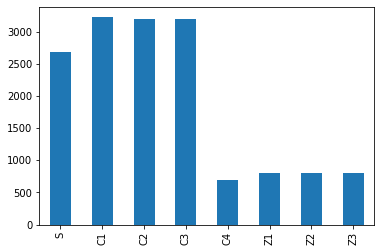

In [244]:
"""
A quick overview of the distribution of loads/positions.
"""

#Breakdown of units by decking location
plotting = testing_y.apply(pd.Series.value_counts)
plotting.loc[1,:].plot(kind='bar')
print(plotting.loc[1,:])

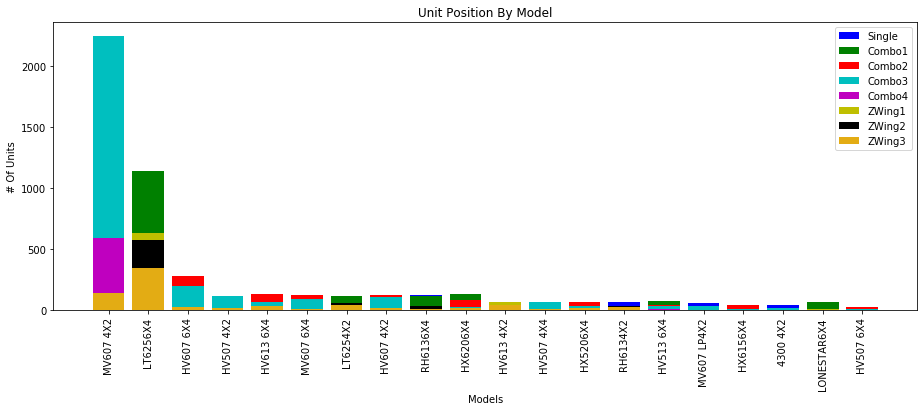

In [243]:
"""
This section is just meant to show prevalence of the the most common units and a break down of the decking
configurations.  The stacked bars are hard to read, but clearly shows a majority of the units are represented by
just 2-4 models.
"""

#DataFrame to analyze by ModelNumber
print_df = pd.DataFrame()
print_df['ModelNumber'] = testing_df['ModelNumber']
print_df[['S','C1','C2','C3','C4','Z1','Z2','Z3']] = testing_y
print_df = print_df.groupby(['ModelNumber']).sum()

#Reduce DataFrame for Plotting
print_df["sum"] = print_df.sum(axis=1)
print_df_filtered = print_df.sort_values(by=['sum'],ascending=False)
print_df_filter =  print_df_filtered['sum']>50
print_df_filtered = print_df_filtered[print_df_filter]

#Create Plot
fig=plt.figure()
ax=fig.add_axes([0,0,2,1])

#Scatter plot with all the positions
ax.bar(print_df_filtered.index, print_df_filtered['S'], color='b', label='Single')
ax.bar(print_df_filtered.index, print_df_filtered['C1'], color='g', label='Combo1')
ax.bar(print_df_filtered.index, print_df_filtered['C2'], color='r', label='Combo2')
ax.bar(print_df_filtered.index, print_df_filtered['C3'], color='c', label='Combo3')
ax.bar(print_df_filtered.index, print_df_filtered['C4'], color='m', label='Combo4')
ax.bar(print_df_filtered.index, print_df_filtered['Z1'], color='y', label='ZWing1')
ax.bar(print_df_filtered.index, print_df_filtered['Z2'], color='k', label='ZWing2')
ax.bar(print_df_filtered.index, print_df_filtered['Z3'], color='#e3ac14', label='ZWing3')

#ax.set_facecolor('#fcf8e8')
ax.set_xlabel('Models')
plt.xticks(rotation=90)
ax.set_ylabel('# Of Units')
ax.set_title('Unit Position By Model')
ax.legend()
plt.show()

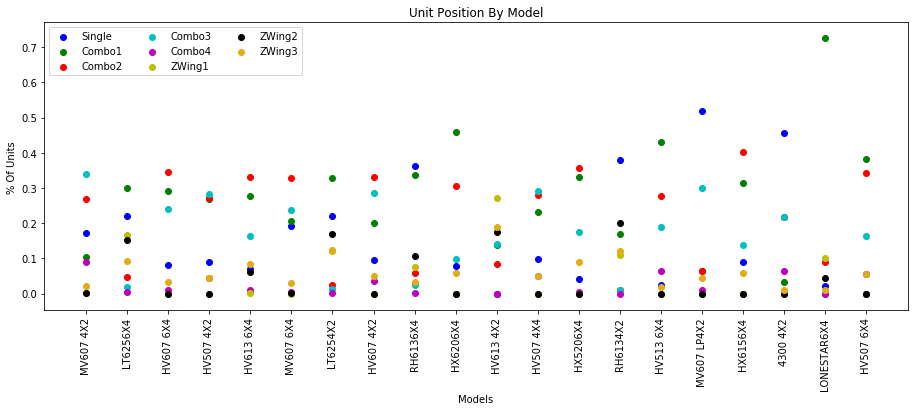

In [245]:
"""
Normalized breakdown of decking configurations.  Each column is a % of that specific model by 
decking configuration.
"""

#DataFrame to analyze by ModelNumber as % of Total
print_df = pd.DataFrame()
print_df['ModelNumber'] = testing_df['ModelNumber']
print_df[['S','C1','C2','C3','C4','Z1','Z2','Z3']] = testing_y
print_df = print_df.groupby(['ModelNumber']).sum()

#Reduce DataFrame for Plotting
print_df["sum"] = print_df.sum(axis=1)
print_df_filtered = print_df.sort_values(by=['sum'],ascending=False)
print_df_filter =  print_df_filtered['sum']>50
print_df_filtered = print_df_filtered[print_df_filter]

#Create Plot
fig=plt.figure()
ax1=fig.add_axes([0,0,2,1])

#Scatter plot with all the positions
ax1.scatter(print_df_filtered.index, print_df_filtered['S'] / print_df_filtered['sum'], color='b', label='Single')
ax1.scatter(print_df_filtered.index, print_df_filtered['C1'] / print_df_filtered['sum'], color='g', label='Combo1')
ax1.scatter(print_df_filtered.index, print_df_filtered['C2'] / print_df_filtered['sum'], color='r', label='Combo2')
ax1.scatter(print_df_filtered.index, print_df_filtered['C3'] / print_df_filtered['sum'], color='c', label='Combo3')
ax1.scatter(print_df_filtered.index, print_df_filtered['C4'] / print_df_filtered['sum'], color='m', label='Combo4')
ax1.scatter(print_df_filtered.index, print_df_filtered['Z1'] / print_df_filtered['sum'], color='y', label='ZWing1')
ax1.scatter(print_df_filtered.index, print_df_filtered['Z2'] / print_df_filtered['sum'], color='k', label='ZWing2')
ax1.scatter(print_df_filtered.index, print_df_filtered['Z3'] / print_df_filtered['sum'], color='#e3ac14', label='ZWing3')

#ax.set_facecolor('#fcf8e8')
ax1.set_xlabel('Models')
plt.xticks(rotation=90)
ax1.set_ylabel('% Of Units')
ax1.set_title('Unit Position By Model')
ax1.legend(ncol=3)
plt.show()

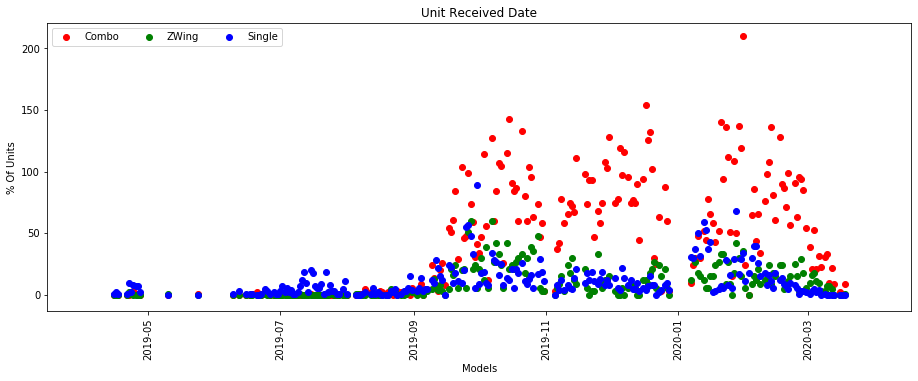

In [246]:
"""
A scatter plot of deck types by the date that the unit is received.
"""

#DataFrame to analyze by ModelNumber as % of Total
print_df = pd.DataFrame()
print_df['UnitReceiveDate'] = testing_df['UnitReceiveDate']
print_df[['S','C1','C2','C3','C4','Z1','Z2','Z3']] = testing_y
print_df = print_df.groupby(['UnitReceiveDate']).sum()

#Reduce DataFrame for Plotting
print_df["sum"] = print_df.sum(axis=1)
print_df["Combo"] = print_df[['C1','C2','C3','C4']].sum(axis=1)
print_df["ZWing"] = print_df[['Z1','Z2','Z3']].sum(axis=1)
print_df_filtered = print_df.sort_values(by=['sum'],ascending=False)
#print_df_filter =  print_df_filtered['sum']00
#print_df_filtered = print_df_filtered[print_df_filter]

#Create Plot
fig=plt.figure()
ax1=fig.add_axes([0,0,2,1])

#Scatter plot with all the positions
ax1.scatter(print_df_filtered.index, print_df_filtered['Combo'], color='r', label='Combo')
ax1.scatter(print_df_filtered.index, print_df_filtered['ZWing'], color='g', label='ZWing')
ax1.scatter(print_df_filtered.index, print_df_filtered['S'], color='b', label='Single')

#ax.set_facecolor('#fcf8e8')
ax1.set_xlabel('Models')
plt.xticks(rotation=90)
ax1.set_ylabel('% Of Units')
ax1.set_title('Unit Received Date')
ax1.legend(ncol=3)
plt.show()

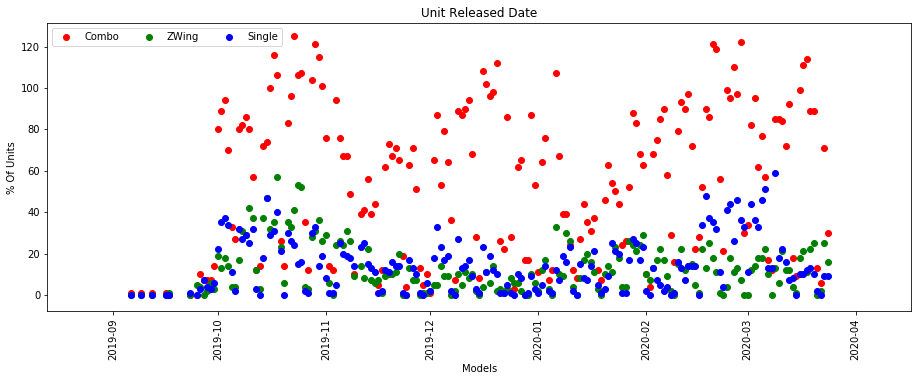

In [248]:
"""
A scatter plot of deck types by the date that the unit is released.  It's basically just a more compact version
of the previos scatter.  Which represents either production at the plant being delayed or rising inventories at
the terminal.  I will need to clarify on the origion of this data point to better clarify.
"""

#DataFrame to analyze by ModelNumber as % of Total
print_df = pd.DataFrame()
print_df['UnitReleaseDate'] = testing_df['UnitReleaseDate']
print_df[['S','C1','C2','C3','C4','Z1','Z2','Z3']] = testing_y
print_df = print_df.groupby(['UnitReleaseDate']).sum()
looksies = testing_df.groupby(['UnitReleaseDate'])['VIN'].count()

#Reduce DataFrame for Plotting
print_df["sum"] = print_df.sum(axis=1)
print_df["Combo"] = print_df[['C1','C2','C3','C4']].sum(axis=1)
print_df["ZWing"] = print_df[['Z1','Z2','Z3']].sum(axis=1)
print_df_filtered = print_df.sort_values(by=['sum'],ascending=False)
#print_df_filter =  print_df_filtered['sum']00
#print_df_filtered = print_df_filtered[print_df_filter]

#Create Plot
fig=plt.figure()
ax1=fig.add_axes([0,0,2,1])

#Scatter plot with all the positions
ax1.scatter(print_df_filtered.index, print_df_filtered['Combo'], color='r', label='Combo')
ax1.scatter(print_df_filtered.index, print_df_filtered['ZWing'], color='g', label='ZWing')
ax1.scatter(print_df_filtered.index, print_df_filtered['S'], color='b', label='Single')
ax1

#ax.set_facecolor('#fcf8e8')
ax1.set_xlabel('Models')
plt.xticks(rotation=90)
ax1.set_ylabel('% Of Units')
ax1.set_title('Unit Released Date')
ax1.legend(ncol=3)
plt.show()

# Classification

I will attempt to predict the deck type and the position using KNN.

In [250]:
"""
Break input variables up by datatypes.  Convert categorical data into a binary table and normalize continuous
variable.  Maybe standardscaler isn't best because it can make them negative, since it centers around 0 with
the variance projected on either side.
"""

#Creating the X matrix
drop_list_x = ['LoadType','LoadUnits','LoadDeckingOrder','LoadZWing','First','Second','Third','UnitReceiveDate',
              'UnitReleaseDate','wheelbase','serial']
X_cat = testing_df.drop(columns=drop_list_x)
X_int = testing_df[['weight','afterframe','wheelbase']]

#standardize continuous variables
st = StandardScaler()
X_int_fit = st.fit_transform(X_int)
X_int_fit = pd.DataFrame(X_int_fit)

#convert categories into binary table
X_enc = pd.get_dummies(X_cat, prefix_sep='_', drop_first=True)
X = X_enc.merge(X_int_fit, how='left',left_index=True, right_index=True)

#I believe droping 'S' will improve it since it would be implied if it's predicted to be all zeros
y = testing_y.drop('S',axis=1)

#Setting up test and train matrixes.  Will convert this to cross validation when I find better model
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size = .30, random_state = 40)

In [251]:
"""
Instantiating and fitting the model.
"""

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [211]:
"""
Testing the accuracy of the model.  Tried making a confusion matrix but couldn't seem to make it work?  The
accuracy of this model is terrible.  I'm not sure I can improve it though... It's not taking into account the 
environment that it's in though, which is why this will never work correctly.
"""

#Compute accuracy on the testing set
test_accuracy = neigh.score(X_test, y_test)
test_accuracy

# Testing Site

Everything below this point is basically for reference and for me to play around with.  Ignore this section if I'm sharing this with you unless I specifically reference it.

In [252]:
"""
Will eventually need to put everthing into a similar pipeline to clean up my code and look professional\


# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsClassifier

drop_list_x = ['LoadType','LoadUnits','LoadDeckingOrder','LoadZWing','First','Second','Third','UnitReceiveDate',
              'UnitReleaseDate','weight','afterframe']
X_cat = testing_df.drop(columns=drop_list_x)
X_int = testing_df[['VIN','weight','afterframe']]
X_enc = pd.get_dummies(X_cat, prefix_sep='_', drop_first=True,columns=X_cat.columns.drop('VIN'))
X = X_enc.merge(X_int, how='left',on='VIN').drop(['VIN'],axis=1)

# Obtain the text data: get_text_data
get_cat_data = FunctionTransformer(lambda x: x.dtypes=='uint8', validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x.dtypes=='float', validate=False)

# Fit and transform the text data: just_text_data
just_text_data = get_cat_data.fit_transform(X)

# Fit and transform the numeric data: just_numeric_data
just_numeric_data = get_numeric_data.fit_transform(X)

# Import FeatureUnion
from sklearn.pipeline import FeatureUnion

# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 40)

# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    #('imputer', Imputer()),
                    ('scaler', StandardScaler())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_cat_data)
                ]))
             ]
        )

# Instantiate nested pipeline: pl
pl = Pipeline([
        ('union', process_and_join_features),
        ('knn', KNeighborsClassifier(n_neighbors=1))
    ])


# Fit pl to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all data: ", accuracy)

pred_x_test = pl.predict(X_test)
"""

'\nWill eventually need to put everthing into a similar pipeline to clean up my code and look professional\n\n# Import FunctionTransformer\nfrom sklearn.preprocessing import FunctionTransformer\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.preprocessing import Imputer\nfrom sklearn.neighbors import KNeighborsClassifier\n\ndrop_list_x = [\'LoadType\',\'LoadUnits\',\'LoadDeckingOrder\',\'LoadZWing\',\'First\',\'Second\',\'Third\',\'UnitReceiveDate\',\n              \'UnitReleaseDate\',\'weight\',\'afterframe\']\nX_cat = testing_df.drop(columns=drop_list_x)\nX_int = testing_df[[\'VIN\',\'weight\',\'afterframe\']]\nX_enc = pd.get_dummies(X_cat, prefix_sep=\'_\', drop_first=True,columns=X_cat.columns.drop(\'VIN\'))\nX = X_enc.merge(X_int, how=\'left\',on=\'VIN\').drop([\'VIN\'],axis=1)\n\n# Obtain the text data: get_text_data\nget_cat_data = FunctionTransformer(lambda x: x.dtypes==\'uint8\', validate=False)\n\n# Obtain the numeric dat

In [253]:
"""
This will be used if I decide on a KNN to choose the best n

# Only use for testing purposes.  This is directly from DataCamp and needs obvi modifications
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 40)

scaler = StandardScaler()
X = scaler.fit_transform(X_train['weight'])
X_train['afterframe'] = scaler.fit_transform(X_train['afterframe'])

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

"""

"\nThis will be used if I decide on a KNN to choose the best n\n\n# Only use for testing purposes.  This is directly from DataCamp and needs obvi modifications\n# Setup arrays to store train and test accuracies\nneighbors = np.arange(1, 9)\ntrain_accuracy = np.empty(len(neighbors))\ntest_accuracy = np.empty(len(neighbors))\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 40)\n\nscaler = StandardScaler()\nX = scaler.fit_transform(X_train['weight'])\nX_train['afterframe'] = scaler.fit_transform(X_train['afterframe'])\n\n# Loop over different values of k\nfor i, k in enumerate(neighbors):\n    # Setup a k-NN Classifier with k neighbors: knn\n    knn = KNeighborsClassifier(n_neighbors=k)\n\n    # Fit the classifier to the training data\n    knn.fit(X_train,y_train)\n    \n    #Compute accuracy on the training set\n    train_accuracy[i] = knn.score(X_train, y_train)\n\n    #Compute accuracy on the testing set\n    test_accuracy[i] = knn.score(X_tes

In [192]:
looksies = testing_df.groupby(['UnitReleaseDate'])['VIN'].count().sort_index()
looksies.sum()

15413